In [1]:
""" Do all of the importing"""

import numpy as np
import matplotlib.pyplot as plt
from  scipy.interpolate import interp1d
import os
import scipy.io as scio
import astropy.io.fits as pyfits
from glob import glob
import multiprocessing as mp
import h5py
from scipy.interpolate import RegularGridInterpolator
import time
import datetime

from breads.instruments.KPIC import KPIC
from breads.fit import fitfm
from breads.grid_search import grid_search
from breads.fit import log_prob

import emcee
import corner

from copy import copy
import pandas as pd
from astropy import constants as const
from  scipy.interpolate import interp1d
from PyAstronomy import pyasl
from petitRADTRANS.radtrans import Radtrans

# from breads.utils import LPFvsHPF

from breads.utils import get_spline_model
from breads.fm.hc_prt_splinefm import hc_prt_splinefm, nonlin_lnprior_func

[Bens-MacBook-Pro-2.local:24226] shmem: mmap: an error occurred while determining whether or not /var/folders/_d/bjkllpj502xbsj6zws9q4msw0000gn/T//ompi.Bens-MacBook-Pro-2.501/jf.0/853934080/sm_segment.Bens-MacBook-Pro-2.501.32e60000.0 could be created.


In [2]:

#if __name__ == "__main__": # This is necessary for multiprocessing to work properly if run in a .py script
    
    # import mkl # This is necessary to limit the number of threads used by numpy and scipy to 1. This is necessary for multiprocessing to work properly.
    # mkl.set_num_threads(1)
    
   

numthreads = 8   # Number of threads to use for multiprocessing. This should be set to the number of physical cores on your machine.
orders = [6,7,8]  # KPIC Orders to use for the analysis. This should be a list of integers.


###dataset vars 
dataobjlist = [] 
fm_funclist = []
fm_paras_list = []


Now we're going to load all of the data for the companion, host, and standard star for multiple datasets

In [3]:
files_2020,sc_fib_2 = [50,51,52,53,65,66,67],1 # remember science fiber is indexed from 0
spec_2020_filelist=[]
datadir = "/Users/bensappey/KPIC/Data/HD_206893/HD_206893_kpic_package/20200929_HD_206893_B/fluxes"
for filenum in files_2020:
    spec_2020_filelist.append(os.path.join(datadir,"nspec200929_{0:04d}_bkgdsub_spectra.fits".format(filenum)))
#print(spec_filelist)


filenums_fib = [42,43,44,45,46,47]
host_2020_filelist = []
datadir = "/Users/bensappey/KPIC/Data/HD_206893/HD_206893_kpic_package/20200929_HD_206893/fluxes"
for filenum in filenums_fib:
    host_2020_filelist.append(os.path.join(datadir, "nspec200929_{0:04d}_bkgdsub_spectra.fits".format(filenum)))
#print(host_filelist)


filenums_fib = [31,32,33,34,35,36,37,38,39,40,41]
A0_2020_filelist = []
datadir = "/Users/bensappey/KPIC/Data/HD_206893/HD_206893_kpic_package/20200929_lam_Cap/fluxes"
for filenum in filenums_fib:
    A0_2020_filelist.append(os.path.join(datadir, "nspec200929_{0:04d}_bkgdsub_spectra.fits".format(filenum)))
#print(A0_filelist)


# load 2022 dataset

filenums_fib,sc_fib_2 = [432,434,436,438],1 # There is the gas cell here
spec_filelist_2=[]
datadir = "/Users/bensappey/KPIC/Data/220720/HD_206893_b/fluxes"
for filenum in filenums_fib:
    spec_filelist_2.append(os.path.join(datadir,"nspec220720_{0:04d}_bkgdsub_spectra.fits".format(filenum)))
# print(spec_filelist_2)

filenums_fib,sc_fib_3 = [433,437],2 # There is the gas cell here
spec_filelist_3=[]
datadir = "/Users/bensappey/KPIC/Data/220720/HD_206893_b/fluxes"
for filenum in filenums_fib:
    spec_filelist_3.append(os.path.join(datadir,"nspec220720_{0:04d}_bkgdsub_spectra.fits".format(filenum)))
print(spec_filelist_3)

filenums_fib = [427,428,429,430,431,440,441,442,443,450,451,452,453]
host_2022_filelist = []
datadir = "/Users/bensappey/KPIC/Data/220720/HD_206893/fluxes"
for filenum in filenums_fib:
    host_2022_filelist.append(os.path.join(datadir, "nspec220720_{0:04d}_bkgdsub_spectra.fits".format(filenum)))
# print(host_filelist)


filenums_fib = [415,416,417,418,419,420,421,422,423,424,425,426]
A0_2022_filelist = []
datadir = "/Users/bensappey/KPIC/Data/220720/lam_Cap/fluxes"
for filenum in filenums_fib:
    A0_2022_filelist.append(os.path.join(datadir, "nspec220720_{0:04d}_bkgdsub_spectra.fits".format(filenum)))
print(A0_2022_filelist)



['/Users/bensappey/KPIC/Data/220720/HD_206893_b/fluxes/nspec220720_0433_bkgdsub_spectra.fits', '/Users/bensappey/KPIC/Data/220720/HD_206893_b/fluxes/nspec220720_0437_bkgdsub_spectra.fits']
['/Users/bensappey/KPIC/Data/220720/lam_Cap/fluxes/nspec220720_0415_bkgdsub_spectra.fits', '/Users/bensappey/KPIC/Data/220720/lam_Cap/fluxes/nspec220720_0416_bkgdsub_spectra.fits', '/Users/bensappey/KPIC/Data/220720/lam_Cap/fluxes/nspec220720_0417_bkgdsub_spectra.fits', '/Users/bensappey/KPIC/Data/220720/lam_Cap/fluxes/nspec220720_0418_bkgdsub_spectra.fits', '/Users/bensappey/KPIC/Data/220720/lam_Cap/fluxes/nspec220720_0419_bkgdsub_spectra.fits', '/Users/bensappey/KPIC/Data/220720/lam_Cap/fluxes/nspec220720_0420_bkgdsub_spectra.fits', '/Users/bensappey/KPIC/Data/220720/lam_Cap/fluxes/nspec220720_0421_bkgdsub_spectra.fits', '/Users/bensappey/KPIC/Data/220720/lam_Cap/fluxes/nspec220720_0422_bkgdsub_spectra.fits', '/Users/bensappey/KPIC/Data/220720/lam_Cap/fluxes/nspec220720_0423_bkgdsub_spectra.fits', 

Loading calibration data here as well. I still have a btsettl planet model here for a check that the forward model is working properly further down

In [4]:


planet_btsettl = "/Users/bensappey/models/BT-Settl_M-0.0_a+0.0/lte015-4.5-0.0a+0.0.BT-Settl.spec.7"
trace_2020_filename = "/Users/bensappey/KPIC/Data/HD_206893/HD_206893_kpic_package/20200929_lam_Cap/calib/nspec200929_0033_trace.fits"
wvs_2020_filename = "/Users/bensappey/KPIC/Data/HD_206893/HD_206893_kpic_package/20200929_HIP_95771/calib/20200929_HIP_95771_psg_wvs_230512.fits"
trace_2022_filename = "/Users/bensappey/KPIC/Data/220720/calibs/trace/nspec220720_0390_trace.fits"
wvs_2022_filename = "/Users/bensappey/KPIC/Data/220720/calibs/wavecal/jasons/20220720_HIP81497_psg_wvs.fits"
wvs_phoenix = "/Users/bensappey/KPIC/Data/public_kpic_data/utils/WAVE_PHOENIX-ACES-AGSS-COND-2011.fits"
A0_phoenix = "/Users/bensappey/KPIC/Data/HD_206893/HD_206893_kpic_package/lte09800-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits"




Create all the data objects for breads to process

In [5]:

dataobj_2020   = KPIC(spec_2020_filelist, trace_2020_filename, wvs_2020_filename,combine_mode="companion",fiber_goal_list=[sc_fib_2,]*len(spec_2020_filelist))
dataobj_2_2022 = KPIC(spec_filelist_2, trace_2022_filename, wvs_2022_filename, combine_mode="companion",fiber_goal_list=[sc_fib_2,]*len(spec_filelist_2))
dataobj_3_2022 = KPIC(spec_filelist_3, trace_2022_filename, wvs_2022_filename, combine_mode="companion", fiber_goal_list=[sc_fib_3,]*len(spec_filelist_3))

dataobj_2020 = dataobj_2020.selec_order(orders)
print(dataobj_2020.wavelengths[0])
dataobj_2_2022 = dataobj_2_2022.selec_order(orders)
dataobj_3_2022 = dataobj_3_2022.selec_order(orders)

A0_2020_obj = KPIC(A0_2020_filelist, trace_2020_filename, wvs_2020_filename, combine_mode="star", fiber_goal_list=[0,0,1,1,1,2,2,2,3,3,3])
A0_2022_obj = KPIC(A0_2022_filelist, trace_2022_filename, wvs_2022_filename, combine_mode="star", fiber_goal_list=[0,0,0,1,1,1,2,2,2,3,3,3]) 
hostobj_2020 = KPIC(host_2020_filelist, trace_2020_filename, wvs_2020_filename, combine_mode="star", fiber_goal_list=[1,1,1,2,2,2])
hostobj_2022 = KPIC(host_2022_filelist, trace_2022_filename, wvs_2022_filename, combine_mode="star", fiber_goal_list=[1,1,1,2,2,1,2,1,2,1,2,1,2])

A0_2020_obj = A0_2020_obj.selec_order(orders)
A0_2022_obj = A0_2022_obj.selec_order(orders)
hostobj_2020 = hostobj_2020.selec_order(orders)
hostobj_2022 = hostobj_2022.selec_order(orders)



/Users/bensappey/repos/breads/breads/instruments/KPIC.py:263: RuntimeWarning: Mean of empty slice
  out_spec = np.nanmean(spectra, axis=0)
/Users/bensappey/repos/breads/breads/instruments/KPIC.py:267: RuntimeWarning: invalid value encountered in divide
  out_errors = np.sqrt(np.nansum(errors**2, axis=0))/np.sum(mask,axis=0)
/Users/bensappey/repos/breads/breads/instruments/KPIC.py:255: RuntimeWarning: divide by zero encountered in divide
  scaling4badpix = (np.nansum(flux_per_spectra,axis=0)/np.sum(np.isfinite(cp_spectra)*flux_per_spectra,axis=0))


/Users/bensappey/KPIC/Data/HD_206893/HD_206893_kpic_package/20200929_HD_206893_B/fluxes/nspec200929_0050_bkgdsub_spectra.fits
/Users/bensappey/KPIC/Data/HD_206893/HD_206893_kpic_package/20200929_HD_206893_B/fluxes/nspec200929_0051_bkgdsub_spectra.fits
/Users/bensappey/KPIC/Data/HD_206893/HD_206893_kpic_package/20200929_HD_206893_B/fluxes/nspec200929_0052_bkgdsub_spectra.fits
/Users/bensappey/KPIC/Data/HD_206893/HD_206893_kpic_package/20200929_HD_206893_B/fluxes/nspec200929_0053_bkgdsub_spectra.fits
/Users/bensappey/KPIC/Data/HD_206893/HD_206893_kpic_package/20200929_HD_206893_B/fluxes/nspec200929_0065_bkgdsub_spectra.fits
/Users/bensappey/KPIC/Data/HD_206893/HD_206893_kpic_package/20200929_HD_206893_B/fluxes/nspec200929_0066_bkgdsub_spectra.fits
/Users/bensappey/KPIC/Data/HD_206893/HD_206893_kpic_package/20200929_HD_206893_B/fluxes/nspec200929_0067_bkgdsub_spectra.fits
/Users/bensappey/KPIC/Data/220720/HD_206893_b/fluxes/nspec220720_0432_bkgdsub_spectra.fits
/Users/bensappey/KPIC/Data/

Since we're dealing with multiple datasets here, we need to append them to the data obj list

In [6]:


dataobjlist.append(dataobj_2020)
dataobjlist.append(dataobj_2_2022)
dataobjlist.append(dataobj_3_2022)
print(dataobjlist)


[<breads.instruments.KPIC.KPIC object at 0x34b0ced00>, <breads.instruments.KPIC.KPIC object at 0x34b0cee80>, <breads.instruments.KPIC.KPIC object at 0x34b0cebe0>]


Defining the shape of the data

In [7]:
nz_2020, nf_2020 = dataobj_2020.data.shape
nz_2022_2, nf_2022_2 = dataobj_2_2022.data.shape
nz_2022_3,nf_2022_3 = dataobj_3_2022.data.shape

min_wv = dataobj_2020.wavelengths[:,orders[0]][0]
max_wv = dataobj_2020.wavelengths[:,orders[-1]][-1]

min_wv_2 = dataobj_2_2022.wavelengths[:,orders[0]][0]
max_wv_2 = dataobj_2_2022.wavelengths[:,orders[-1]][-1]

min_wv_3 = dataobj_3_2022.wavelengths[:,orders[0]][0]
max_wv_3 = dataobj_3_2022.wavelengths[:,orders[-1]][-1]

print(min_wv,max_wv)
print(min_wv_2,max_wv_2)
print(min_wv_3,max_wv_3)


2.2914876824086075 2.4868365789427958
2.291246395967723 2.4865995780110683
2.291246395967723 2.4865995780110683


Now the fun begins: we first choose the species that we want to look at with the petitRADTRANS atmosphere
Then we make a base atmosphere. This defines the pressure space, molecules and other parameters like the wavelength range
Since we're looking at KPIC data (R~35,000), we are using the line-by-line, high-resolution opacity lists
The other thing to change is the path_input_data which is where you are storing your petitRADTRANS 'input_data' folder

In [8]:

# %%
line_species = ['1H2-16O', '12C-16O', '12C-1H4']


from petitRADTRANS.radtrans import Radtrans
prt_base_atm = Radtrans(pressures = np.logspace(-10,2,130),
                    line_species = line_species,
                    rayleigh_species = ['H2', 'He'],
                    gas_continuum_contributors = ['H2-H2', 'H2-He'],
                    wavelength_boundaries = [min_wv_2-0.02, max_wv_2+0.02],
                    line_opacity_mode = 'lbl',
                    line_by_line_opacity_sampling=1,
                    path_input_data='/Users/bensappey/models/petitRADTRANS_opacity/input_data/')





Loading Radtrans opacities...
 Loading line opacities of species '1H2-16O' from file '/Users/bensappey/models/petitRADTRANS_opacity/input_data/opacities/lines/line_by_line/H2O/1H2-16O/1H2-16O__POKAZATEL.R1e6_0.3-28mu.xsec.petitRADTRANS.h5'... Done.
 Loading line opacities of species '12C-16O' from file '/Users/bensappey/models/petitRADTRANS_opacity/input_data/opacities/lines/line_by_line/CO/12C-16O/12C-16O__HITEMP.R1e6_0.3-28mu.xsec.petitRADTRANS.h5'... Done.
 Loading line opacities of species '12C-1H4' from file '/Users/bensappey/models/petitRADTRANS_opacity/input_data/opacities/lines/line_by_line/CH4/12C-1H4/12C-1H4__Hargreaves.R1e6_0.3-28mu.xsec.petitRADTRANS.h5'... Done.
 Successfully loaded all line opacities
 Loading CIA opacities for H2-H2 from file '/Users/bensappey/models/petitRADTRANS_opacity/input_data/opacities/continuum/collision_induced_absorptions/H2--H2/H2--H2-NatAbund/H2--H2-NatAbund__BoRi.R831_0.6-250mu.ciatable.petitRADTRANS.h5'... Done.
 Loading CIA opacities for H2

/Users/bensappey/anaconda3/envs/petit/lib/python3.9/site-packages/petitRADTRANS/_input_data_loader.py:347: UserWarning: file 'wlen.dat' lacks a source
  warnings.warn(f"file '{file}' lacks a source")
/Users/bensappey/anaconda3/envs/petit/lib/python3.9/site-packages/petitRADTRANS/_input_data_loader.py:350: UserWarning: file 'wlen.dat' lacks spectral information (resolution: , range: )
  warnings.warn(f"file '{file}' lacks spectral information "


Now we define some atmospheric parameters. The most important one where is probably the choice of atmospheric profile. I have used guillot_global in the past

In [9]:

from petitRADTRANS import physical_constants as cst


prt_atm_paras = {}


prt_atm_paras['line_species'] = line_species
prt_atm_paras['planet_radius'] = 1.0*cst.r_jup_mean
prt_atm_paras['reference_gravity'] = 10**3.5
prt_atm_paras['reference_pressure'] = 0.01

prt_atm_paras['atm_profile'] = 'guillot_global'
prt_atm_paras['kappa_IR'] = 0.01
prt_atm_paras['gamma'] = 0.4
prt_atm_paras['delta'] = 0.1 # The delta parameter of Guillot et al. 2010, used for retrieval guillot global only (instead of kappa and gamma)
prt_atm_paras['intrinsic_temperature'] = 200.
prt_atm_paras['equilibrium_temperature'] = 1500.
prt_atm_paras['redistribution_coefficient'] = 0.25 # The redistribution coefficient of the irradiance. A value of 1 corresponds to the substellar point, 1/2 for the day-side average and 1/4 for the global average.

prt_atm_paras['metallicity'] = 0.0 # The metallicity in log10 relative to solar, used for guillot_metallic only
prt_atm_paras['infrared_mean_opacity_solar'] = 0.0 #(cm2.s-1) infrared mean opacity for a solar metallicity (Z = 0) atmosphere



#options are:
    #guillot_global
    #guillot_global_ret
    #guillot_dayside
    #guillot
    #guillot_metallic
    #guillot_modif
    #ret_model
    #isothermal



More standard breads things defining tellurics etc. 

In [10]:

with pyfits.open(wvs_phoenix) as hdulist:
    phoenix_wvs = hdulist[0].data / 1.e4
crop_phoenix = np.where((phoenix_wvs > min_wv_3 - 0.02) * (phoenix_wvs < max_wv_3 + 0.02))
phoenix_wvs = phoenix_wvs[crop_phoenix]
with pyfits.open(A0_phoenix) as hdulist:
    phoenix_A0 = hdulist[0].data[crop_phoenix]
print("broadening A0 phoenix model")

# model_broadspec_2020 = dataobj_2020.broaden(waves,flux,loc=sc_fib_2,mppool=None) #changed mypool to None
phoenix_A0_broad_2020 = dataobj_2020.broaden(phoenix_wvs,phoenix_A0,loc=sc_fib_2,mppool=None)
phoenix_A0_func_2020 = interp1d(phoenix_wvs, phoenix_A0_broad_2020, bounds_error=False, fill_value=np.nan)
transmission_2020 = A0_2020_obj.data[:,sc_fib_3]/phoenix_A0_func_2020(A0_2020_obj.wavelengths[:,sc_fib_3])

# model_broadspec_2_2022 = dataobj_2_2022.broaden(waves,flux,loc=sc_fib_2,mppool=None) #changed mypool to None
phoenix_A0_broad_2_2022 = dataobj_2_2022.broaden(phoenix_wvs,phoenix_A0,loc=sc_fib_2,mppool=None)
phoenix_A0_func_2_2022 = interp1d(phoenix_wvs, phoenix_A0_broad_2_2022, bounds_error=False, fill_value=np.nan)
transmission_2_2022 = A0_2022_obj.data[:,sc_fib_2]/phoenix_A0_func_2_2022(A0_2022_obj.wavelengths[:,sc_fib_2])

# model_broadspec_3_2022 = dataobj_3_2022.broaden(waves,flux,loc=sc_fib_2,mppool=None) #changed mypool to None
phoenix_A0_broad_3_2022 = dataobj_3_2022.broaden(phoenix_wvs,phoenix_A0,loc=sc_fib_3,mppool=None)
phoenix_A0_func_3_2022 = interp1d(phoenix_wvs, phoenix_A0_broad_3_2022, bounds_error=False, fill_value=np.nan)
transmission_3_2022 = A0_2022_obj.data[:,sc_fib_3]/phoenix_A0_func_3_2022(A0_2022_obj.wavelengths[:,sc_fib_3])

# mypool.close()
# mypool.join()

# %%
host_spectrum_2020 = hostobj_2020.data[:,sc_fib_2]
host_spectrum_2 = hostobj_2022.data[:,sc_fib_2]
host_spectrum_3 = hostobj_2022.data[:,sc_fib_3]

# planet_f_2020 = interp1d(grid_wvs, model_broadspec_2020, bounds_error=False, fill_value=np.nan)
# planet_f_2 = interp1d(grid_wvs, model_broadspec_2_2022, bounds_error=False, fill_value=np.nan)
# planet_f_3 = interp1d(grid_wvs, model_broadspec_3_2022, bounds_error=False, fill_value=np.nan)



broadening A0 phoenix model


Construct the forward model
Spline
Here the new parameters are the base atmosphere and the atmospheric parameters 

In [11]:

N_nodes_per_order = 5 
nodes = []


ordersize = int(nz_2020//np.size(dataobj_2020.orders)) # probably equal to 2048...
for order_id in range(np.size(dataobj_2020.orders)):
    minwvord = dataobj_2020.wavelengths[order_id*ordersize,sc_fib_2]
    maxwvord = dataobj_2020.wavelengths[(order_id+1)*ordersize-1,sc_fib_2]
    nodes.append(np.linspace(minwvord,maxwvord,N_nodes_per_order,endpoint=True))
fm_paras_2020 = {"prt_base_atm":prt_base_atm,"prt_atm_paras":prt_atm_paras,"transmission":transmission_2020,"star_spectrum":host_spectrum_2020,
                "boxw":1,"psfw":0.01,"badpixfraction":0.75,"nodes":nodes,"loc":sc_fib_2}
fm_func = hc_prt_splinefm
fm_paras_list.append(fm_paras_2020)
fm_funclist.append(fm_func)


Only looking at a single dataset, 2020, right now

In [12]:

# nodes=[]
# ordersize = int(nz_2022_2//np.size(dataobj_2_2022.orders)) # probably equal to 2048...
# for order_id in range(np.size(dataobj_2_2022.orders)):
#     minwvord = dataobj_2_2022.wavelengths[order_id*ordersize,sc_fib_2]
#     maxwvord = dataobj_2_2022.wavelengths[(order_id+1)*ordersize-1,sc_fib_2]
#     nodes.append(np.linspace(minwvord,maxwvord,N_nodes_per_order,endpoint=True))
# fm_paras_2 = {"atm_grid":myinterpgrid,"atm_grid_wvs":grid_wvs,"transmission":transmission_2_2022,"star_spectrum":host_spectrum_2,
#                 "boxw":1,"psfw":0.01,"badpixfraction":0.75,"nodes":nodes,"loc":sc_fib_2}
# fm_func = hc_atmgrid_splinefm
# fm_paras_list.append(fm_paras_2)
# fm_funclist.append(fm_func)

# nodes=[]
# ordersize = int(nz_2022_3//np.size(dataobj_3_2022.orders)) # probably equal to 2048...
# for order_id in range(np.size(dataobj_3_2022.orders)):
#     minwvord = dataobj_3_2022.wavelengths[order_id*ordersize,sc_fib_3]
#     maxwvord = dataobj_3_2022.wavelengths[(order_id+1)*ordersize-1,sc_fib_3]
#     nodes.append(np.linspace(minwvord,maxwvord,N_nodes_per_order,endpoint=True))
# fm_paras_3 = {"atm_grid":myinterpgrid,"atm_grid_wvs":grid_wvs,"transmission":transmission_3_2022,"star_spectrum":host_spectrum_3,
#                 "boxw":1,"psfw":0.01,"badpixfraction":0.75,"nodes":nodes,"loc":sc_fib_3}
# fm_func = hc_atmgrid_splinefm
# fm_paras_list.append(fm_paras_3)
# fm_funclist.append(fm_func)


In [13]:

# nonlin_labels = ["C/O Ratio Value", "v$sin i$ (km/s)", "Radial Velocity (km/s)"]
nonlin_paras_mins = np.array([1200,3.5, 0, -50])
nonlin_paras_maxs = np.array([2000,5.0, 50, 50])

lnprob = fitfm(nonlin_paras=[1500,4.5,15,10], dataobj=dataobj_2020, fm_func=fm_func, fm_paras=fm_paras_2020, computeH0=False, bounds=None)

# %%
print(fm_funclist)
print(fm_paras_list)

# %%


Generating Atmosphere . . . 
[<function hc_prt_splinefm at 0x34b9039d0>]
[{'prt_base_atm': <petitRADTRANS.radtrans.Radtrans object at 0x34b91aa90>, 'prt_atm_paras': {'line_species': ['1H2-16O', '12C-16O', '12C-1H4'], 'planet_radius': 6991100000.0, 'reference_gravity': 3162.2776601683795, 'reference_pressure': 0.01, 'atm_profile': 'guillot_global', 'kappa_IR': 0.01, 'gamma': 0.4, 'delta': 0.1, 'intrinsic_temperature': 200.0, 'equilibrium_temperature': 1500.0, 'redistribution_coefficient': 0.25, 'metallicity': 0.0, 'infrared_mean_opacity_solar': 0.0}, 'transmission': array([-6.21047940e-14,  8.82038455e-14, -5.38711010e-14, ...,
       -8.80182092e-14, -1.95827699e-13,  1.01080870e-13]), 'star_spectrum': array([ 4.92657281, -5.54976289, -2.78716351, ..., -3.47549646,
       -2.28970287, -0.81771896]), 'boxw': 1, 'psfw': 0.01, 'badpixfraction': 0.75, 'nodes': [array([2.29148768, 2.30282638, 2.31416508, 2.32550377, 2.33684247]), array([2.36276365, 2.37444101, 2.38611836, 2.39779572, 2.4094

In [14]:

nwalkers = 128
nsteps = 20
ndim = np.size(nonlin_paras_mins)
p0 = np.random.rand(nwalkers, ndim) * (nonlin_paras_maxs-nonlin_paras_mins)[None,:] + nonlin_paras_mins[None,:]
print(np.nanmedian(p0, axis=0))


os.environ["OMP_NUM_THREADS"] = "1"
# Caution: Parallelization in emcee can make it much slower than sequential. You should run some tests to make sure
# what the optimal number of processes is or if sequential is just better.
mypool = mp.Pool(processes=8)

#optional: Setup Backend (saves final state of chain, able to load, analyze, or resume MCMC with saved chain)
#set backend to None if you don't want to save the chain
dt = str(datetime.datetime.now())
date = dt[0:10]
timenow = dt[11:16]
bkend_file = "hd_206893_b_emcee_prt_test{0}_{1}-{2}_steps.h5".format(date,timenow,nsteps)
backend = emcee.backends.HDFBackend(bkend_file)


sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[dataobj_2020, fm_func, fm_paras_2020, nonlin_lnprior_func],pool=None,backend=backend)
# args=[dataobj, fm_func, fm_paras,nonlin_lnprior_func]
# print(log_prob(p0[0],dataobj, fm_func, fm_paras))

# Run and time burnout
start = time.time()
state = sampler.run_mcmc(p0, nsteps, progress=True)
end = time.time()
print("burnout over // time {0}s".format(end-start))

sampler.reset()
sampler.run_mcmc(state, nsteps, progress=True)

samples = sampler.get_chain(flat=True)
samples_gc = samples[:, 0]
mypool.close()
mypool.join()

figure = corner.corner(samples, labels=["Temp", "logg", "vsini", "RV"], range=[(1200, 2000), (3.5, 5.0), (0, 50), (-50, 50)])

plt.savefig('/Users/bensappey/Downloads/prt_{}_try_multithread.png'.format(date),dpi=300)
plt.show()





[1643.61785896    4.37511727   22.97651712   -9.51530088]


TypeError: nonlin_lnprior_func() missing 1 required positional argument: 'nonlin_paras'

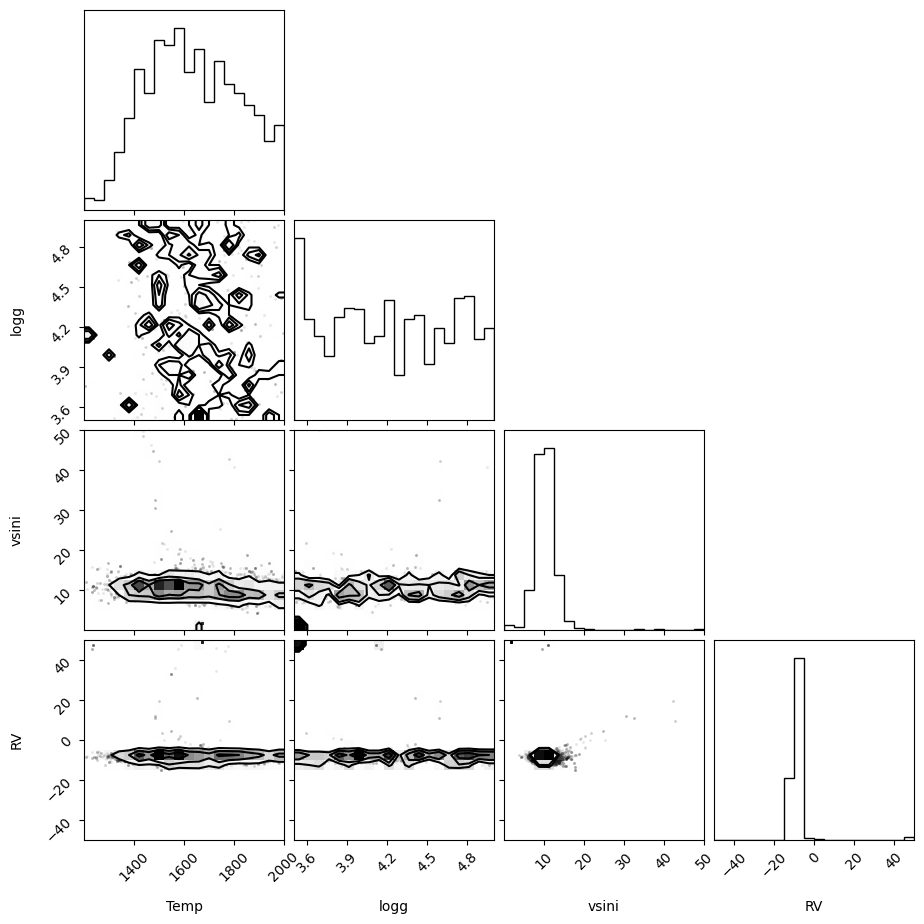

In [15]:
backend_file = '/Users/bensappey/repos/breads/demos/hd_206893_b_emcee_prt_test2024-10-31_10:36-50_steps.h5'
# Load the backend file
backend = emcee.backends.HDFBackend(backend_file)

# Get the samples from the backend
samples = backend.get_chain(flat=True)

# Plot the samples using corner
figure = corner.corner(samples, labels=["Temp", "logg", "vsini", "RV"], range=[(1200, 2000), (3.5, 5.0), (0, 50), (-50, 50)])
plt.show()